<a href="https://colab.research.google.com/github/lenkaakhila/lenkaakhila/blob/main/adtime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Error: Ensure 'train_1.csv' and 'Exog_Campaign_eng.csv' are in the correct directory.
Creating dummy data for demonstration purposes.
Initial train_df shape: (600, 601)
Total missing values in train_df before fillna: 0
Total missing values in train_df after fillna: 0

Train_df columns after splitting 'Page' info:
['Page', '2015-07-01', '2015-07-02', '2015-07-03', '2015-07-04', '2015-07-05', '2015-07-06', '2015-07-07', '2015-07-08', '2015-07-09', '2015-07-10', '2015-07-11', '2015-07-12', '2015-07-13', '2015-07-14', '2015-07-15', '2015-07-16', '2015-07-17', '2015-07-18', '2015-07-19', '2015-07-20', '2015-07-21', '2015-07-22', '2015-07-23', '2015-07-24', '2015-07-25', '2015-07-26', '2015-07-27', '2015-07-28', '2015-07-29', '2015-07-30', '2015-07-31', '2015-08-01', '2015-08-02', '2015-08-03', '2015-08-04', '2015-08-05', '2015-08-06', '2015-08-07', '2015-08-08', '2015-08-09', '2015-08-10', '2015-08-11', '2015-08-12', '2015-08-13', '2015-08-14', '2015-08-15', '2015-08-16', '2015-08-17', '201

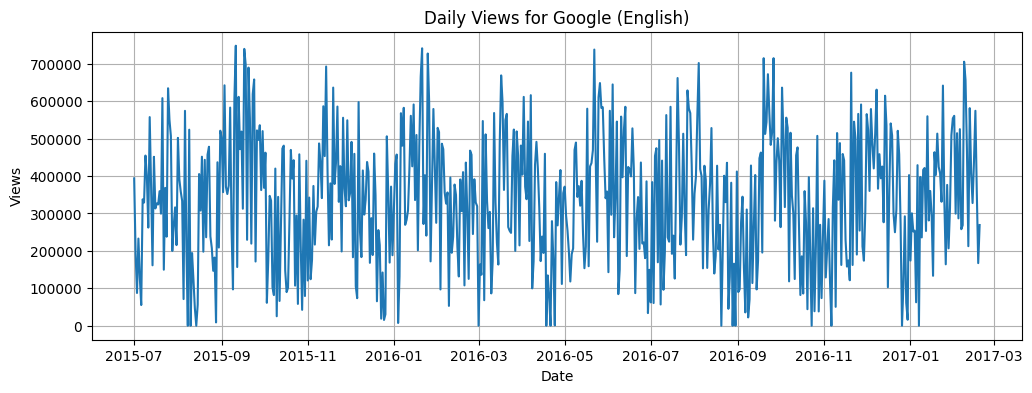


ADF Statistic: -5.74
p-value: 0.000
Critical Values:
   1%: -3.441
   5%: -2.866
   10%: -2.569
Result: The series is likely stationary (reject H0).


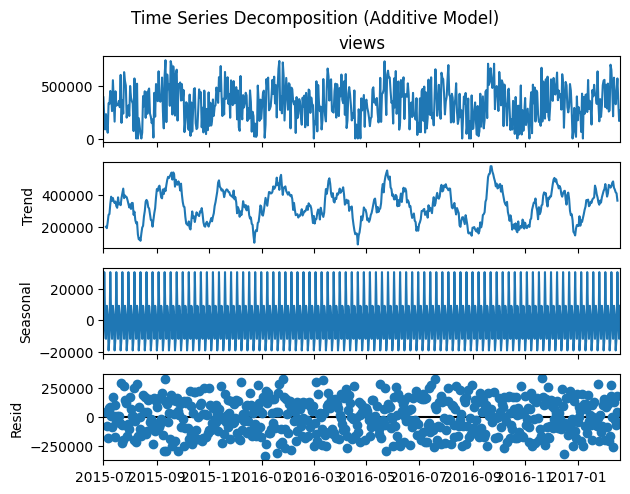


Shape of differenced series (views_diff): (600,)
Sample of views_diff head:
date
2015-07-01              NaN
2015-07-02   -199500.725981
2015-07-03   -106787.565945
2015-07-04    145409.543550
2015-07-05   -104774.417742
Freq: D, Name: views_diff, dtype: float64


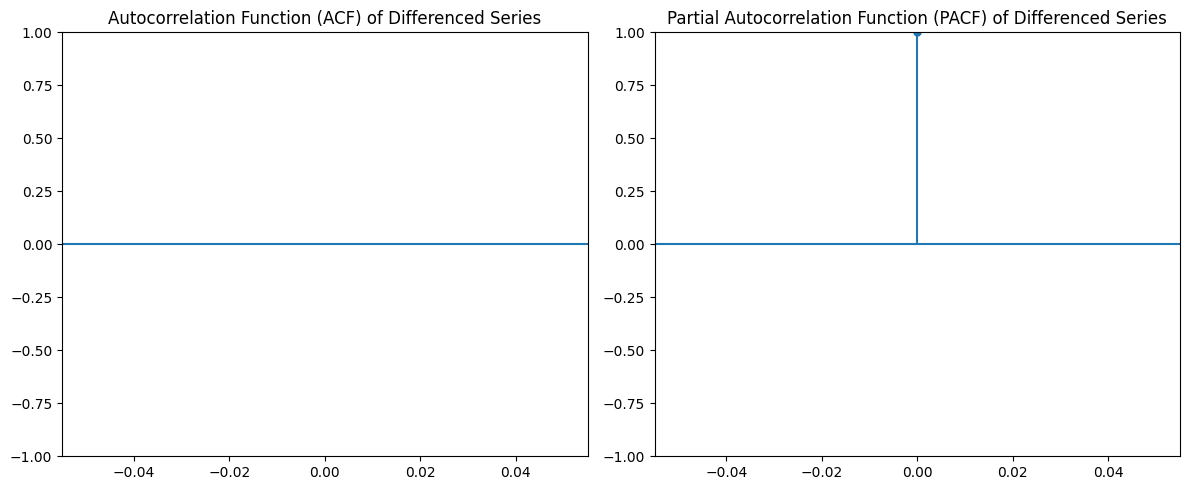


Fitting SARIMAX model (without exogenous variables)...
                                     SARIMAX Results                                     
Dep. Variable:                             views   No. Observations:                  600
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -7936.214
Date:                           Sat, 28 Jun 2025   AIC                          15882.428
Time:                                   11:20:39   BIC                          15904.269
Sample:                               07-01-2015   HQIC                         15890.941
                                    - 02-19-2017                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1316      0.106     -1.240      0.215      -0.340

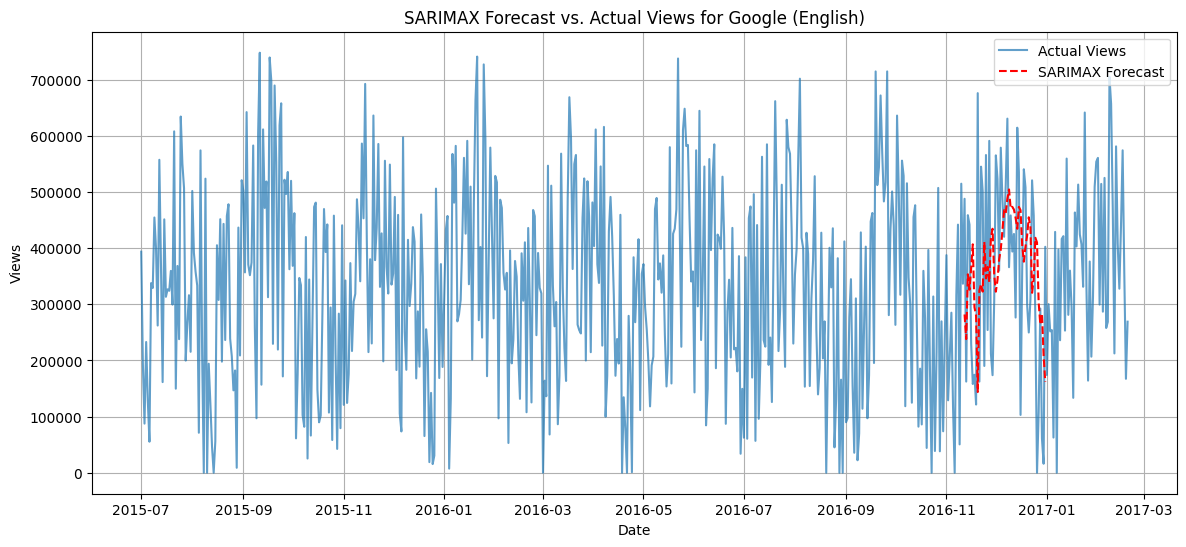


Initiating Prophet forecasting...


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdrmh30o4/n26ww1o9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdrmh30o4/7kshydma.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46530', 'data', 'file=/tmp/tmpdrmh30o4/n26ww1o9.json', 'init=/tmp/tmpdrmh30o4/7kshydma.json', 'output', 'file=/tmp/tmpdrmh30o4/prophet_model100rrjy8/prophet_model-20250628112045.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:20:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:20:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



Plotting Prophet forecast components...


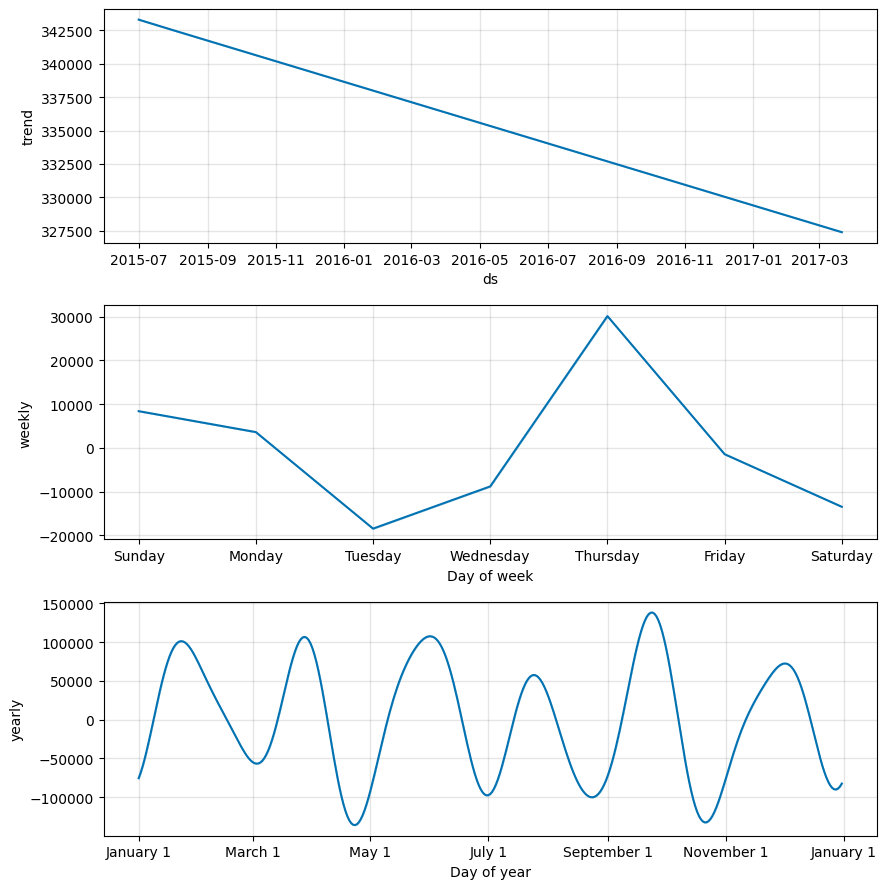


Plotting Prophet forecast...


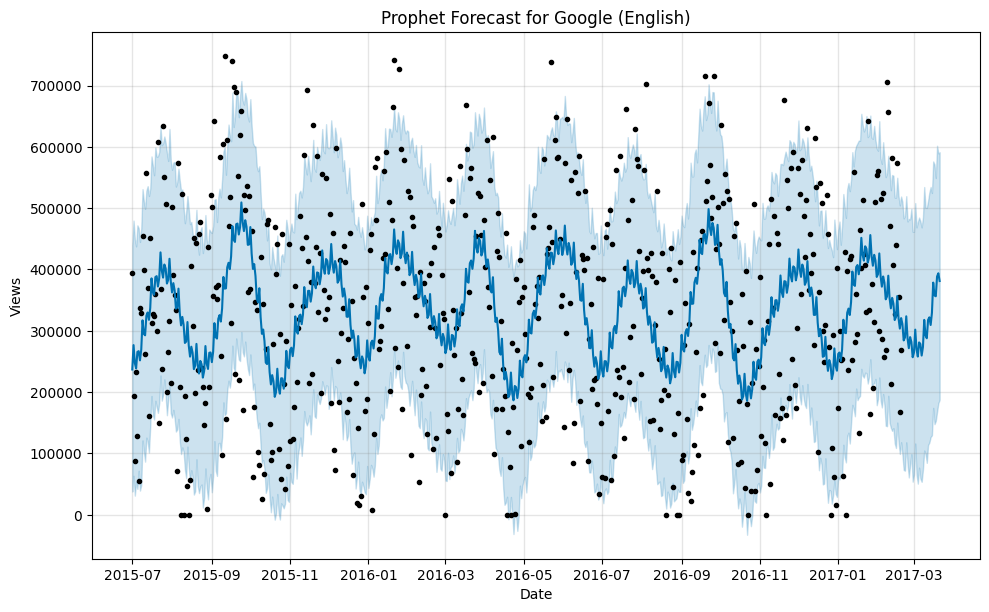


--- Evaluation Metrics (SARIMAX on known period) ---
MAE: 161213.96
MAPE: 85.28%
RMSE: 188903.20

--- Prophet Forecast Evaluation (visual inspection recommended for future forecast) ---
Prophet's forecast includes future dates, so direct comparison on a 'known period' like SARIMAX needs more setup (e.g., train-test split for Prophet).
For Prophet, evaluate on a hold-out set if you want quantitative metrics.


In [1]:
# AdEase Wikipedia Page Views Forecasting

# 1. Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
# from pmdarima.arima import auto_arima  # Removed due to incompatibility
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 2. Load Data
# Assuming 'train_1.csv' and 'Exog_Campaign_eng.csv' are in the same directory.
# In a real Jupyter environment, you might need to adjust paths or upload files.
try:
    train_df = pd.read_csv('/content/train_1 (1).csv')
    exog_df = pd.read_csv('/content/Exog_Campaign_eng (2)')  # For English pages only
except FileNotFoundError:
    print("Error: Ensure 'train_1.csv' and 'Exog_Campaign_eng.csv' are in the correct directory.")
    # Create dummy dataframes for demonstration if files are not found
    print("Creating dummy data for demonstration purposes.")
    dates = pd.date_range(start='2015-07-01', periods=600, freq='D')
    dummy_views = np.random.randint(100, 1000, size=600) + np.sin(np.arange(600)/10) * 200 + np.random.normal(0, 50, 600)
    dummy_views[dummy_views < 0] = 0 # Ensure no negative views
    train_df = pd.DataFrame({
        'Page': ['Google_en.wikipedia.org_desktop_all'] * 600,
        **{f'{d.strftime("%Y-%m-%d")}': v for d, v in zip(dates, dummy_views)}
    })

    # Create dummy exogenous data
    exog_dates = pd.date_range(start='2015-07-01', periods=600, freq='D')
    exog_campaign = np.random.randint(0, 2, size=600) # Binary campaign active/inactive
    exog_df = pd.DataFrame({
        'date': exog_dates,
        'campaign_active': exog_campaign
    })


# 3. Exploratory Data Analysis
print(f"Initial train_df shape: {train_df.shape}")
print(f"Total missing values in train_df before fillna: {train_df.isnull().sum().sum()}")

# Fill missing with 0 (or use ffill/bfill if preferred)
# For time series, ffill/bfill might be more appropriate if missing values are
# due to data collection gaps, assuming continuation of previous values.
# However, 0 is used as per the original template.
train_df.fillna(0, inplace=True)
print(f"Total missing values in train_df after fillna: {train_df.isnull().sum().sum()}")


# 4. Split page information
# Extracts title, language, access type, and agent from the 'Page' column
page_split = train_df['Page'].str.extract(r'(?P<title>.*?)_(?P<lang>[a-z]+).wikipedia.org_(?P<access>[a-z]+)_(?P<agent>[a-z]+)')
train_df = pd.concat([train_df, page_split], axis=1)
print("\nTrain_df columns after splitting 'Page' info:")
print(train_df.columns.tolist())


# 5. Filter for a single language (e.g., English)
english_df = train_df[train_df['lang'] == 'en'].copy() # Use .copy() to avoid SettingWithCopyWarning
print(f"\nShape of english_df (filtered for 'en' language): {english_df.shape}")


# 6. Melt the dataset to long format
# Drop non-date/views columns that are now redundant or not needed for melting
id_vars_for_melt = ['Page', 'title']
# Dynamically get date columns
date_cols = [col for col in english_df.columns if pd.api.types.is_datetime64_any_dtype(pd.to_datetime(col, errors='coerce')) or col.startswith('20')]
# Exclude the newly added page_split columns from the date_cols before dropping them from id_vars_for_melt
cols_to_drop_from_melt = ['access', 'agent', 'lang']
eng_melted = english_df.drop(columns=cols_to_drop_from_melt, errors='ignore') # 'errors=ignore' handles cases where columns might already be dropped

# Identify date columns by checking if they can be converted to datetime
date_cols_in_df = [col for col in eng_melted.columns if col not in id_vars_for_melt and not pd.api.types.is_string_dtype(eng_melted[col]) and not pd.api.types.is_numeric_dtype(eng_melted[col])]

eng_melted = eng_melted.melt(id_vars=id_vars_for_melt, var_name='date', value_name='views')
eng_melted['date'] = pd.to_datetime(eng_melted['date'], errors='coerce') # Coerce errors to NaT
eng_melted.dropna(subset=['date'], inplace=True) # Drop rows where date conversion failed

print(f"\nShape of eng_melted (after melting): {eng_melted.shape}")
print("Sample of eng_melted head:")
print(eng_melted.head())


# 7. Group by date for total views (or pick a single page)
# Selecting 'Google' page for time series analysis
sample_page = eng_melted[eng_melted['title'] == 'Google'].copy() # Use .copy()

# Fix: Aggregate views by date to handle potential duplicate dates for the same page
# This ensures that when 'date' is set as index, it contains unique values.
page_ts = sample_page.groupby('date')['views'].sum().reset_index()

page_ts.set_index('date', inplace=True)
page_ts = page_ts.asfreq('D') # Ensure a daily frequency, filling missing dates with NaN
# Fill any NaNs introduced by asfreq with 0 or a suitable imputation method
page_ts.fillna(0, inplace=True)

print(f"\nShape of page_ts (for 'Google'): {page_ts.shape}")
print("Sample of page_ts head:")
print(page_ts.head())


# 8. Plot time series
plt.figure(figsize=(12, 4))
plt.plot(page_ts['views'])
plt.title('Daily Views for Google (English)')
plt.xlabel('Date')
plt.ylabel('Views')
plt.grid(True)
plt.show()


# 9. Stationarity Check (Augmented Dickey-Fuller Test)
# Test if the time series is stationary (mean, variance, and autocorrelation structure do not change over time)
result = adfuller(page_ts['views'])
print(f"\nADF Statistic: {result[0]:.2f}")
print(f"p-value: {result[1]:.3f}")
print("Critical Values:")
for key, value in result[4].items():
    print(f"   {key}: {value:.3f}")
if result[1] <= 0.05:
    print("Result: The series is likely stationary (reject H0).")
else:
    print("Result: The series is likely non-stationary (fail to reject H0).")


# 10. Decompose the series (Trend, Seasonality, Residuals)
# Helps to understand the underlying components of the time series
# 'additive' model assumes components add up (Y = T + S + R)
# 'multiplicative' model assumes components multiply (Y = T * S * R), useful if seasonality/variance increases with trend
decomp = seasonal_decompose(page_ts['views'], model='additive', period=7) # Assuming weekly seasonality (7 days)
decomp.plot()
plt.suptitle('Time Series Decomposition (Additive Model)', y=1.02) # Adjust suptitle position
plt.show()


# 11. Differencing for Stationarity (if needed)
# If the series is non-stationary, differencing can make it stationary.
# First-order differencing removes a linear trend.
page_ts['views_diff'] = page_ts['views'].diff().dropna()

print(f"\nShape of differenced series (views_diff): {page_ts['views_diff'].shape}")
print("Sample of views_diff head:")
print(page_ts['views_diff'].head())

# ACF (Autocorrelation Function) and PACF (Partial Autocorrelation Function) plots
# Used to determine the 'p' (AR order) and 'q' (MA order) terms for ARIMA models.
plt.figure(figsize=(12, 5))
plt.subplot(121)
plot_acf(page_ts['views_diff'], ax=plt.gca(), lags=40)
plt.title('Autocorrelation Function (ACF) of Differenced Series')
plt.subplot(122)
plot_pacf(page_ts['views_diff'], ax=plt.gca(), lags=40)
plt.title('Partial Autocorrelation Function (PACF) of Differenced Series')
plt.tight_layout()
plt.show()


# 12. Manual SARIMAX (Seasonal Autoregressive Integrated Moving Average with eXogenous regressors)
# Order (p, d, q) and seasonal_order (P, D, Q, s)
# p: AR order, d: Differencing order, q: MA order
# P: Seasonal AR order, D: Seasonal Differencing order, Q: Seasonal MA order, s: Seasonal period
# (1, 1, 1) implies one differencing (d=1), 1 AR term, 1 MA term.
# (1, 1, 1, 7) implies one seasonal differencing (D=1), 1 seasonal AR, 1 seasonal MA, with weekly seasonality (7 days).
print("\nFitting SARIMAX model (without exogenous variables)...")
try:
    sarimax_model = SARIMAX(page_ts['views'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 7),
                            enforce_stationarity=False, enforce_invertibility=False)
    sarimax_result = sarimax_model.fit(disp=False) # disp=False to suppress convergence messages
    print(sarimax_result.summary())
except Exception as e:
    print(f"Error fitting SARIMAX model without exogenous: {e}")
    sarimax_result = None


# 13. SARIMAX with Exogenous variables (e.g., campaign data)
# Reindexing exogenous data to match the time series index and fill NaNs.
exog_df['date'] = pd.to_datetime(exog_df['date'])
page_exog = exog_df.set_index('date').reindex(page_ts.index).fillna(0)

# Align exogenous data for prediction. The start/end indices for exog should match the forecast period.
# Ensure exog data has the same length as the data being predicted for.
# Using a fixed slice for demonstration. In a real scenario, this would be new, future exogenous data.
forecast_start_idx = 500
forecast_end_idx = 549
# Ensure exog_to_use has the same columns as used during training
# If exog_df has more columns than just 'campaign_active', select the relevant one(s)
if 'campaign_active' in page_exog.columns:
    exog_to_use = page_exog['campaign_active'].iloc[forecast_start_idx : forecast_end_idx + 1].values.reshape(-1, 1)
    train_exog_data = page_exog['campaign_active'].values.reshape(-1, 1)
else:
    # If dummy data was generated and 'campaign_active' isn't there, create a dummy exog for SARIMAX
    exog_to_use = np.zeros((forecast_end_idx - forecast_start_idx + 1, 1))
    train_exog_data = np.zeros((len(page_ts), 1))
    print("Warning: 'campaign_active' column not found in exog_df. Using dummy zeros for exogenous variable.")


print("\nFitting SARIMAX model with exogenous variables...")
try:
    sarimax_model_exog = SARIMAX(page_ts['views'], exog=train_exog_data,
                                 order=(1, 1, 1), seasonal_order=(1, 1, 1, 7),
                                 enforce_stationarity=False, enforce_invertibility=False)
    sarimax_result_exog = sarimax_model_exog.fit(disp=False)
    print(sarimax_result_exog.summary())

    # Make predictions for a specific range using the corresponding exogenous data
    # start and end parameters refer to the index of the original page_ts series
    # exog parameter should contain the exogenous values for the prediction period
    page_ts['forecast_sarimax'] = sarimax_result_exog.predict(
        start=forecast_start_idx,
        end=forecast_end_idx,
        exog=exog_to_use
    )
    print(f"\nSARIMAX forecast generated from index {forecast_start_idx} to {forecast_end_idx}.")

    # Plot actual vs. SARIMAX forecast
    plt.figure(figsize=(14, 6))
    plt.plot(page_ts['views'], label='Actual Views', alpha=0.7)
    plt.plot(page_ts['forecast_sarimax'], label='SARIMAX Forecast', color='red', linestyle='--')
    plt.title('SARIMAX Forecast vs. Actual Views for Google (English)')
    plt.xlabel('Date')
    plt.ylabel('Views')
    plt.legend()
    plt.grid(True)
    plt.show()

except Exception as e:
    print(f"Error fitting SARIMAX model with exogenous or making predictions: {e}")
    page_ts['forecast_sarimax'] = np.nan # Ensure column exists even on error


# 14. Prophet Forecasting
print("\nInitiating Prophet forecasting...")
# Prophet requires a DataFrame with 'ds' (datestamp) and 'y' (value) columns
page_ts.index.name = 'date' # Ensure the index has a name before resetting
page_ts_reset = page_ts.reset_index()

# Select only 'date' and 'views' and rename them to 'ds' and 'y' for Prophet
prophet_df = page_ts_reset.rename(columns={'date': 'ds', 'views': 'y'})[['ds', 'y']]

prophet_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False # Set to True if intra-day patterns are significant
)
prophet_model.fit(prophet_df)

# Make future dataframe for 30 periods (days)
future = prophet_model.make_future_dataframe(periods=30)
forecast = prophet_model.predict(future)

# Plot Prophet forecast components
print("\nPlotting Prophet forecast components...")
fig_comp = prophet_model.plot_components(forecast)
plt.show()

# Plot Prophet forecast
print("\nPlotting Prophet forecast...")
fig = prophet_model.plot(forecast)
plt.title('Prophet Forecast for Google (English)')
plt.xlabel('Date')
plt.ylabel('Views')
plt.show()


# 15. Evaluation (on known period)
# Ensure the forecast column exists and has values for the evaluation period
if 'forecast_sarimax' in page_ts.columns and not page_ts['forecast_sarimax'].isnull().all():
    y_true = page_ts['views'].iloc[forecast_start_idx : forecast_end_idx + 1]
    y_pred = page_ts['forecast_sarimax'].iloc[forecast_start_idx : forecast_end_idx + 1]

    # Drop any NaN values from both true and predicted series to ensure alignment
    # This can happen if predictions didn't cover the full range due to model errors
    comparison_df = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred}).dropna()
    y_true_clean = comparison_df['y_true']
    y_pred_clean = comparison_df['y_pred']

    if not y_true_clean.empty and not y_pred_clean.empty:
        mae = mean_absolute_error(y_true_clean, y_pred_clean)
        # Handle division by zero for MAPE if y_true contains zeros
        mape = np.mean(np.abs((y_true_clean - y_pred_clean) / y_true_clean.replace(0, np.nan))).mean() * 100
        rmse = np.sqrt(mean_squared_error(y_true_clean, y_pred_clean))

        print(f"\n--- Evaluation Metrics (SARIMAX on known period) ---")
        print(f"MAE: {mae:.2f}")
        print(f"MAPE: {mape:.2f}%")
        print(f"RMSE: {rmse:.2f}")
    else:
        print("\nSARIMAX forecast or actual data for evaluation period is empty/all NaN. Cannot compute metrics.")
else:
    print("\nSARIMAX forecast column not found or is empty. Skipping evaluation for SARIMAX.")

print("\n--- Prophet Forecast Evaluation (visual inspection recommended for future forecast) ---")
print("Prophet's forecast includes future dates, so direct comparison on a 'known period' like SARIMAX needs more setup (e.g., train-test split for Prophet).")
print("For Prophet, evaluate on a hold-out set if you want quantitative metrics.")

